<a href="https://colab.research.google.com/github/aarlova/images/blob/main/masks_to_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/aarlova/images.git

Cloning into 'images'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [1]:
from PIL import Image, ImageOps, ImageCms
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.morphology import erosion, dilation#, opening, closing, white_tophat)
# from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk
from skimage import morphology
import cv2
from google.colab.patches import cv2_imshow

mask_f = '/content/images/17121963 [d=1.99203,x=64741,y=18924,w=996,h=996].png'
mask_f_1 = '/content/images/17121963 [d=1.99203,x=65737,y=19920,w=996,h=996].png'
masks = [mask_f,mask_f_1]

def plot_comparison(original, filtered, filter_name):
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    plt.show()

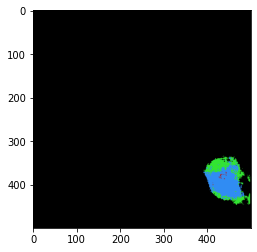

In [2]:
im = Image.open(mask_f)
plot1 = plt.imshow(im)
plot1

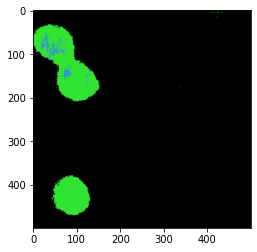

In [40]:
im1 = Image.open(mask_f_1)
plot11 = plt.imshow(im1)
plot11

In [4]:
im_gray = ImageOps.grayscale(im)
image_arr = np.asarray(im_gray, dtype=np.uint8)
# plt.imshow(image_arr, cmap = 'gray')


In [5]:
im_gray1 = ImageOps.grayscale(im1)
image_arr1 = np.asarray(im_gray1, dtype=np.uint8)
# plt.imshow(image_arr1, cmap='gray')

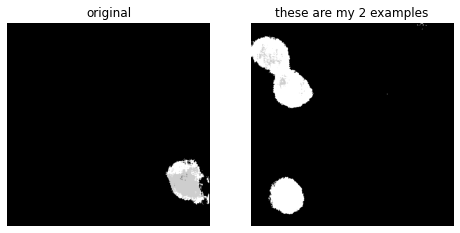

In [6]:
plot_comparison(image_arr, image_arr1, 'these are my 2 examples') #ignore the title "original" on the left

First example - just one follicle detected:



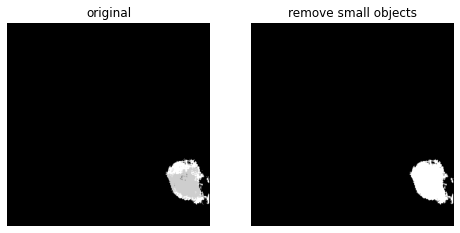

In [7]:
rmv_small = morphology.remove_small_objects(image_arr.astype(bool), 10, connectivity=2)
plot_comparison(image_arr, rmv_small, 'remove small objects')

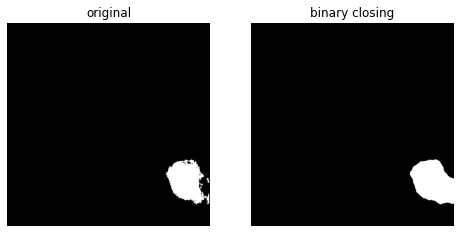

In [8]:
bin_closing = morphology.binary_closing(rmv_small, disk(15))
plot_comparison(rmv_small, bin_closing, 'binary closing')


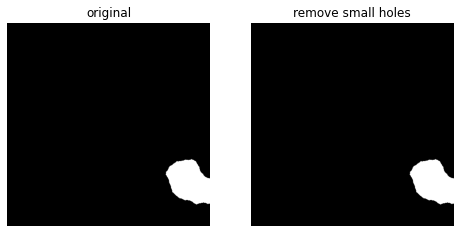

In [9]:
rmv_small_holes = morphology.remove_small_holes(bin_closing, 100)
plot_comparison(bin_closing, rmv_small_holes, 'remove small holes')


In [10]:
# must convert back to uint8?
rmv_small_holes = rmv_small_holes.astype(np.uint8)
bin_closing = bin_closing.astype(np.uint8)

This is just to compare how circle detector works on original mask and on mask after all manipulations + thresholding

found  4 circles


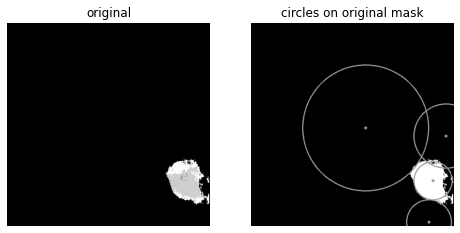

In [12]:
minDist = 100
param1 = 50
param2 = 10
minRadius = 15
maxRadius = 500

image_arr = np.asarray(im_gray, dtype=np.uint8)
ret, thresh = cv2.threshold(image_arr, 0, 255, 0) # <- this works
img = thresh

circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1, minDist, param1=param1,param2=param2,minRadius=minRadius,maxRadius=maxRadius)
# print(circles)

print('found ',len(circles[0]), 'circles')

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(img,(i[0],i[1]),i[2],(155,155,155),2)
    # draw the center of the circle
    cv2.circle(img,(i[0],i[1]),2,(155,155,155),3)

plot_comparison(image_arr, img, 'circles on original mask')

[[[448.5 390.5  47.4]]]
found  1 circles


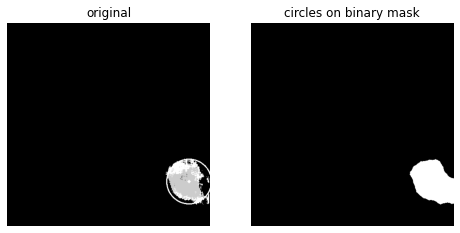

In [19]:
### Circle detector on thresholded image
## I don't really understand why this works when thresholding rmv_small_holes with cv2.threshold but NOT without it - isn't it the same array at this point?

ret, thresh = cv2.threshold(rmv_small_holes, 0, 255, 0) # <- this works

minDist = 100
param1 = 50
param2 = 10
minRadius = 15
maxRadius = 500

img = thresh.copy()
orig_grey_img = image_arr.copy()
# img = rmv_small_holes.copy() # <- this doesn't work 

# circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1, minDist, param1=param1,param2=param2,minRadius=minRadius,maxRadius=maxRadius)
# print(circles)

# print('found ',len(circles[0]), 'circles')

# circles = np.uint16(np.around(circles))
# for i in circles[0,:]:
#     # draw the outer circle
#     cv2.circle(image_arr,(i[0],i[1]),i[2]+6,(155,155,155),2)
#     # draw the center of the circle
#     cv2.circle(image_arr,(i[0],i[1]),2,(155,155,155),3)

# plot_comparison(image_arr, img, 'circles on manipulated mask')

orig_grey_img = image_arr.copy()

circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1, minDist, param1=param1,param2=param2,minRadius=minRadius,maxRadius=maxRadius)
print(circles)

print('found ',len(circles[0]), 'circles')

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(orig_grey_img,(i[0],i[1]),i[2]+8,(155,155,155),2)
    # draw the center of the circle
    cv2.circle(orig_grey_img,(i[0],i[1]),2,(155,155,155),3)

plot_comparison(orig_grey_img, img, 'circles on binary mask')


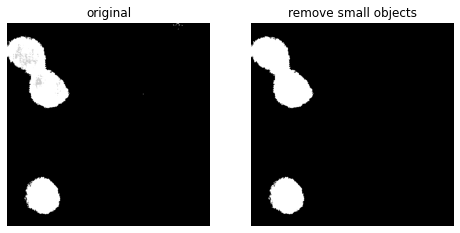

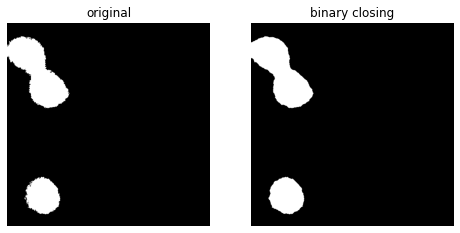

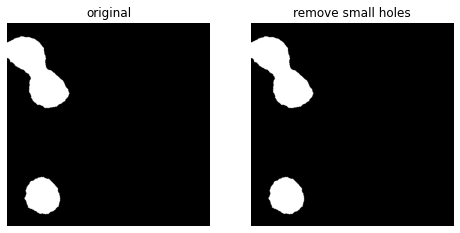

In [11]:
## same stuff for the 2nd example mask

rmv_small1 = morphology.remove_small_objects(image_arr1.astype(bool), 10, connectivity=2)
plot_comparison(image_arr1, rmv_small1, 'remove small objects')

bin_closing1 = morphology.binary_closing(rmv_small1, disk(7))
plot_comparison(rmv_small1, bin_closing1, 'binary closing')

rmv_small_holes1 = morphology.remove_small_holes(bin_closing1, 100)
plot_comparison(bin_closing1, rmv_small_holes1, 'remove small holes')

rmv_small_holes1 = rmv_small_holes1.astype(np.uint8)

[[[ 42.5  84.5  51.9]
  [ 89.5 423.5  45.2]
  [102.5 165.5  42.2]]]
found  3 circles


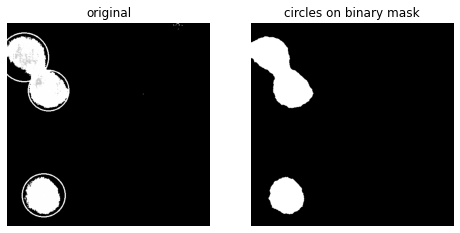

In [20]:
ret, thresh = cv2.threshold(rmv_small_holes1, 0, 255, 0)

minDist = 100
param1 = 50
param2 = 10
minRadius = 15
maxRadius = 500

img = thresh.copy()
orig_grey_img1 = image_arr1.copy()

circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1, minDist, param1=param1,param2=param2,minRadius=minRadius,maxRadius=maxRadius)
print(circles)

print('found ',len(circles[0]), 'circles')

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(orig_grey_img1,(i[0],i[1]),i[2]+8,(155,155,155),2)
    # draw the center of the circle
    cv2.circle(orig_grey_img1,(i[0],i[1]),2,(155,155,155),3)

plot_comparison(orig_grey_img1, img, 'circles on binary mask')

All circles [[[ 42  84  52]
  [ 90 424  45]
  [102 166  42]]]


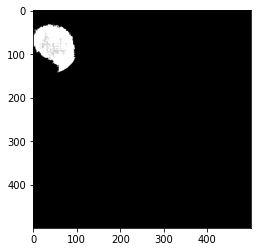

Unique predicted classes in mask:  [124 154]
the winning class (numeric) is 154
the winning class (translated) is Primordial
Original Circle detected on tile:  POLYGON ((188 168, 187.4992115739085 157.8062174057257, 186.001669161936 147.7106065103227, 183.5217949161497 137.8103935655359, 180.0834713811738 128.2009230340307, 175.7198114922289 118.9747393700963, 170.4728396794648 110.2206957659614, 164.3930871497247 102.0230984469809, 157.539105243401 94.46089475659912, 149.9769015530192 87.60691285027542, 141.7793042340387 81.52716032053536, 133.0252606299039 76.28018850777113, 123.7990769659694 71.91652861882622, 114.1896064344642 68.47820508385031, 104.2893934896775 65.99833083806406, 94.19378259427445 64.50078842609155, 84.00000000000017 64, 73.80621740572587 64.5007884260915, 63.71060651032285 65.99833083806401, 53.81039356553611 68.47820508385023, 44.20092303403086 71.91652861882609, 34.97473937009644 76.28018850777097, 26.22069576596154 81.52716032053517, 18.02309844698107 87.6069

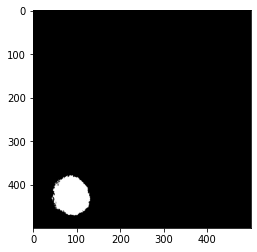

Unique predicted classes in mask:  [124 154]
the winning class (numeric) is 154
the winning class (translated) is Primordial
Original Circle detected on tile:  POLYGON ((270 848, 269.5666254004977 839.1784573703395, 268.2706752362907 830.4418710185485, 266.1246302158988 821.8743790470984, 263.1491579260158 813.558491087142, 259.3729137913519 805.5742936856602, 254.8322651072291 797.9986790282359, 249.5709408026464 790.9046044252719, 243.6396103067893 784.3603896932108, 237.0953955747282 778.4290591973537, 230.0013209717643 773.167734892771, 222.4257063143399 768.6270862086481, 214.4415089128582 764.8508420739843, 206.1256209529017 761.8753697841013, 197.5581289814517 759.7293247637093, 188.8215426296606 758.4333745995023, 180.0000000000001 758, 171.1784573703397 758.4333745995023, 162.4418710185486 759.7293247637092, 153.8743790470986 761.8753697841012, 145.5584910871421 764.8508420739842, 137.5742936856604 768.6270862086479, 129.998679028236 773.1677348927708, 122.9046044252721 778.42

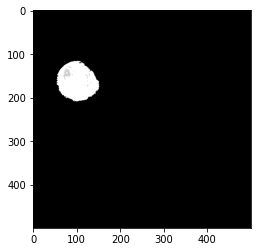

Unique predicted classes in mask:  [124 154]
the winning class (numeric) is 154
the winning class (translated) is Primordial
Original Circle detected on tile:  POLYGON ((288 332, 287.5955170404645 323.7665602123169, 286.3859635538714 315.6124129506453, 284.3829882015056 307.6160871106252, 281.6058807309481 299.8545916813325, 278.0813862052618 292.4026741066162, 273.8434474334138 285.3321004263535, 268.9328780824699 278.7109641302538, 263.39696961967 272.60303038033, 257.2890358697463 267.0671219175301, 250.6678995736467 262.1565525665862, 243.5973258933839 257.9186137947382, 236.1454083186676 254.3941192690519, 228.383912889375 251.6170117984945, 220.3875870493549 249.6140364461287, 212.2334397876832 248.4044829595355, 204.0000000000001 248, 195.766560212317 248.4044829595354, 187.6124129506454 249.6140364461286, 179.6160871106253 251.6170117984944, 171.8545916813326 254.3941192690518, 164.4026741066164 257.9186137947381, 157.3321004263535 262.1565525665861, 150.7109641302539 267.06712

In [124]:
# create a new mask from circles
# fill mask with values of the original mask 
# find the majority class inside each circle
# assign class to each circle

%matplotlib inline
from shapely.geometry import Polygon
from shapely.geometry.point import Point
import re

label_dict = {154: 'Primordial'}

print('All circles', circles)


def cirlces_to_polys(circles):
  regions = []
  region_labels = []
  for i in range(len(circles[0])):
    # 1. Get a new mask from a circle & fill mask with values of the original mask
    mask = np.zeros(image_arr1.shape[:2], dtype="uint8")
    mask = cv2.circle(mask,(circles[0][i][0],circles[0][i][1]),circles[0][i][2]+8,(255), -1)

    masked = np.where(mask > 0, image_arr1, mask)
    plt.imshow(masked, cmap='gray')
    plt.show()

    # 2. find the majority class inside each circle
    vals = np.unique(masked)
    vals = vals[vals > 0] # exclude zeros from unique values list
    print('Unique predicted classes in mask: ', vals)

    foll_class = vals[np.argmax([np.count_nonzero(masked[masked == i]) for i in vals])]
    print('the winning class (numeric) is', foll_class)

    foll_class_word = label_dict[foll_class]
    print('the winning class (translated) is', foll_class_word)

    # 1. Turn detected circle into shapely Polygon - get center x,y of a circle, buffer to circle's radius * downsample factor
    p = Point(circles[0][i][0]*2, circles[0][i][1]*2)
    poly_circle = p.buffer(circles[0][i][2]*2)

    print('Original Circle detected on tile: ', poly_circle)

    # 2. Get tile WSI coords from the tile name
    # print('Tile name: ', mask_f_1)
    tile_coords_xy = re.search('x=(?P<x>\d+),y=(?P<y>\d+)',mask_f_1)
    tile_x = int(tile_coords_xy.group('x'))
    tile_y = int(tile_coords_xy.group('y'))
    # print('Tile top left coords: ', tile_x, tile_y)

    # 3. Translate tile-relative coords of Polygon to WSI-relative coords
    new_ext_x = np.array(poly_circle.exterior.coords.xy[0]) + tile_x
    new_ext_y = np.array(poly_circle.exterior.coords.xy[1]) + tile_y

    new_coords = list(zip(new_ext_x, new_ext_y))
    # new_poly_circle = Polygon(new_coords)
    regions.append(new_coords)
    region_labels.append(foll_class_word)

    print('Translated Polygon on WSI: ', new_poly_circle)

  return regions, region_labels

regions, region_labels = cirlces_to_polys(circles)

print('\nNumber of regions in list', len(regions),  '\nNumber of labels in list:', len(region_labels))


In [125]:
from shapely.geometry import Polygon, mapping
import json

region_colors = {'NOS':-77704,
              'Antral':-3348737,
              'Transitional':3181811,
              'Primordial':-13441998,
              'Corpus Luteum':-16770432,
              'Multilayer No Oocyte':3448731,
              'Multi-oocytic':-1644979,
              'Secondary':-3342388,
              'Intermediate Antral':13368731,
              'Primary':-5039590,
              'Small Antral':-5116141,
              'Large Antral':-32640,
              'Secondary No Nuclei':-9568001,
              'Ovulated Antral Follicle':-12711951,
              'Transforming Primary':-5718196,
              'Margin':3448737,
              'margin':3448737,
              'Area':3448737}


xmlsave = 'test.json'

dumped = []
def write_qupath(xmlsave, regions, region_labels):
    trythis = '['
    for i in range(0, len(regions)):
        if len(regions[i]) >2:
            roi = Polygon(regions[i])
            print('this is roi', roi)
            label = region_labels[i]
            trythis += json.dumps(
                {"type": "Feature", "id": "PathAnnotationObject", "geometry": mapping(roi),
                 "properties": {"classification": {"name": label, "colorRGB": region_colors[label]}, "isLocked": False,
                                "measurements": []}}, indent=4)
            if i < len(regions) - 1:
                trythis += ','
        else:
            dumped.append([region_labels[i], regions[i]])
    trythis += ']'
    with open(xmlsave, 'w') as outfile:
        outfile.write(trythis)

write_qupath(xmlsave, regions, region_labels)

this is roi POLYGON ((65925 20088, 65924.49921157392 20077.80621740573, 65923.00166916194 20067.71060651032, 65920.52179491615 20057.81039356553, 65917.08347138118 20048.20092303403, 65912.71981149224 20038.9747393701, 65907.47283967947 20030.22069576596, 65901.39308714973 20022.02309844698, 65894.5391052434 20014.4608947566, 65886.97690155302 20007.60691285027, 65878.77930423403 20001.52716032054, 65870.0252606299 19996.28018850777, 65860.79907696597 19991.91652861883, 65851.18960643446 19988.47820508385, 65841.28939348967 19985.99833083807, 65831.19378259427 19984.50078842609, 65821 19984, 65810.80621740573 19984.50078842609, 65800.71060651033 19985.99833083807, 65790.81039356554 19988.47820508385, 65781.20092303403 19991.91652861883, 65771.9747393701 19996.28018850777, 65763.22069576597 20001.52716032054, 65755.02309844698 20007.60691285027, 65747.4608947566 20014.4608947566, 65740.60691285027 20022.02309844698, 65734.52716032053 20030.22069576596, 65729.28018850776 20038.9747393701

In [ ]:
# # 1. Get a new mask from a circle & fill mask with values of the original mask
# mask = np.zeros(image_arr1.shape[:2], dtype="uint8")
# mask = cv2.circle(mask,(circles[0][0][0],circles[0][0][1]),circles[0][0][2]+8,(255), -1)


# masked = np.where(mask > 0, image_arr1, mask)
# cv2_imshow(masked)


# # 2. find the majority class inside each circle
# vals = np.unique(masked)
# vals = vals[vals > 0] # exclude zeros from unique values list
# print(vals)

# foll_class = vals[np.argmax([np.count_nonzero(masked[masked == i]) for i in vals])]
# print('the winning class (numeric) is', foll_class)

# label_dict = {154: 'Primordial'}

# foll_class_word = label_dict[foll_class]
# print('the winning class (translated) is', foll_class_word)

# 3. assign class to circle? Circle needs to be a Polygon first - make a list of Polygons in tile, and a list of classes - or use MetaPolygon class?


In [ ]:
# # turn circle into Polygon
# # with coordinates on WSI and class

# # print(circles[0][0][0]) # collection, n-th circle, x-center/y-center/radius

# # 1. Turn detected circle into shapely Polygon - get center x,y of a circle, buffer to circle's radius * downsample factor
# p = Point(circles[0][0][0], circles[0][0][1])
# poly_circle = p.buffer(circles[0][0][2]*2)

# print('Original Circle detected on tile: ', poly_circle)

# # 2. Get tile WSI coords from the tile name
# print('Tile name: ', mask_f_1)
# tile_coords_xy = re.search('x=(?P<x>\d+),y=(?P<y>\d+)',mask_f_1)
# tile_x = int(tile_coords_xy.group('x'))
# tile_y = int(tile_coords_xy.group('y'))
# print('Tile top left coords: ', tile_x, tile_y)

# # 3. Translate tile-relative coords of Polygon to WSI-relative coords
# new_ext_x = np.array(poly_circle.exterior.coords.xy[0]) + tile_x
# new_ext_y = np.array(poly_circle.exterior.coords.xy[1]) + tile_y

# new_coords = list(zip(new_ext_x, new_ext_y))
# new_poly_circle = Polygon(new_coords)

# print('Translated Polygon on WSI: ', new_poly_circle)

# # !!!!!!! check if/how magnification must be taken into account !!!!!!!